In [1]:
from matplotlib import pyplot as plt
from kats.consts import TimeSeriesData
import pandas as pd
from utils import save_fig_for_raport, dataframe_to_latex_tabular 
from pandas.plotting import autocorrelation_plot
import pandas.plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector

In [4]:
cat_id_list = [
  # Dataset 1
         2,
         6,
         9,
         10,
         11,
         13,
         20,
         22,
         24,
         26,
         27,
         28,
         29,
         32,
         33,
         34,
         39,
         41,
         51,
         54,
      # Dataset 2
        12532,
        11694,
        11716,
        11950,
        11195,
        11998,
        274,
        11407,
        46,
        11326,
        11335,
        12197,
        11693,
        11780,
        12502,
        11866,
        11400,
        12256,
        10320,
        10030,
        # Seasonal dataset
        12322,
        11428,
        11850,
        11852,
        273,
        11036,
        11213,
]

In [2]:
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_all_2022_04_26.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
#raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

In [9]:
print(raw_data.count())
data_filtered_cats = raw_data.loc[raw_data['cat_id'].isin(cat_id_list)]
print(data_filtered_cats.count())
data_filtered_cats.head()
data_filtered_cats.to_csv("../datasets/raw/market_insights_overview_all_2022_04_26_filtered.csv", index=False)

id                 41941504
product_id         41941504
manufacturer_id    41941504
cat_id             41941504
root_cat_id        41941504
date               41941504
hits               41941504
clicks             41941504
last_modified      41941504
dtype: int64
id                 6771528
product_id         6771528
manufacturer_id    6771528
cat_id             6771528
root_cat_id        6771528
date               6771528
hits               6771528
clicks             6771528
last_modified      6771528
dtype: int64


,hits,date
788,17,2019-09-16
1292,12,2019-09-16
1316,11,2019-09-16
1777,9,2019-09-16
1904,8,2019-09-16
...,...,...
41941006,1,2022-04-25
41941007,1,2022-04-25
41941220,1,2022-04-25
41941224,1,2022-04-25


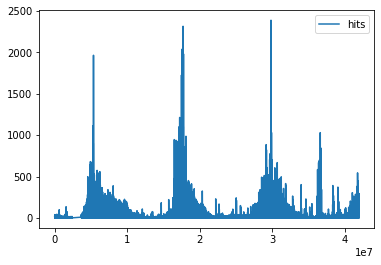

In [20]:
raw_data.loc[raw_data["cat_id"] == 11037][["hits"]].plot()
raw_data.loc[raw_data["cat_id"] == 11037][["hits", "date"]]

In [21]:
categories = pd.read_csv("../datasets/raw/solr_categories_all_2022_02_14.csv")
# Join market_insight table with category names
category_names = categories[[ "internal_doc_id", "title"]]
category_id_to_names_map = dict(map(lambda x: (x["internal_doc_id"], x["title"]), category_names.to_dict("records")))
category_name_to_id_map = dict(map(lambda x: (x["title"], x["internal_doc_id"]), category_names.to_dict("records")))

In [22]:

data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).sum()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]

# Join with category names
data_grouped = pd.merge(data_grouped , category_names, how="left", left_on=["cat_id"], right_on=["internal_doc_id"])
data_grouped.rename(columns={"title": "cat_name"}, inplace=True)
data_grouped.drop(columns=["internal_doc_id"], inplace=True, axis=1)

data_chosen_categories = data_grouped[["interest", "date", "cat_id", "cat_name"]]
data = data_chosen_categories

<AxesSubplot:>

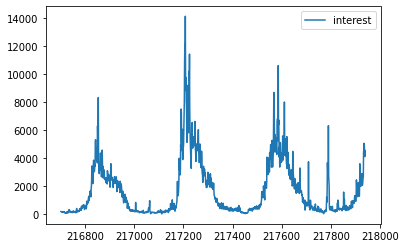

In [23]:
data.loc[data["cat_id"] == 11037][["interest"]].plot()

In [24]:
# Fill in all missing days
#data_grouped_filled_dates = data_chosen_categories.groupby(pd.Grouper(key="date", freq='D')).sum()

#data = data_grouped_filled_dates
#data.head()

In [25]:
# Pivot table by cat_id
data_by_cat_id = data.pivot(index=["date"], columns=["cat_id", "cat_name"])["interest"]
data_by_cat_id.head()

cat_id,2,5,6,9,10,11,13,14,15,16,...,13839,13840,13841,13843,13844,13845,13846,13847,13848,13849
cat_name,Bærbar PC,Prosessor (CPU),Digitalkamera,Harddisk og SSD,Hovedkort,PC-høyttaler,Kabinett,Kontrollerkort,Minnekortleser,Diverse lydkort,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,,,,,,,,,,,,,,,,,,,,,
2018-12-02,2751.0,1065.0,468.0,873.0,620.0,173.0,502.0,12.0,17.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-03,3307.0,1044.0,519.0,918.0,668.0,151.0,618.0,14.0,19.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-04,3461.0,1036.0,581.0,947.0,600.0,157.0,523.0,1.0,3.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-05,3158.0,1072.0,451.0,1106.0,582.0,145.0,553.0,3.0,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-06,3245.0,921.0,432.0,1078.0,559.0,108.0,444.0,3.0,6.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
corr_categories = [2, 6, 9, 10, 11, 13, 20]

seasonal_categories_cat_name =["Vinterjakke",
"Vintersko",
"Langrennski",
"Skisko",
"Varmeovn",
"Snøfreser",
"Snøskuffe",]

seasonal_categories = list(map(lambda x: category_name_to_id_map[x], seasonal_categories_cat_name))
seasonal_categories

[12322, 11428, 11850, 11852, 273, 11036, 11213]

## Decompose time series
We can decompose each series in into its trend, seasonality and residuals (rest).
Then we can use the dicky-fuller test on the residuals to check if the series is stationary.
If the p-value is < 0.05 it is stationary.
Results: The risiduals are mostly stationary

In [33]:
nettverkskabler = data_grouped.loc[data["cat_id"] ==  11037]
#nettverkskabler['date'] =  pd.to_datetime(raw_data['date'])
nettverkskabler = nettverkskabler.rename(columns={"date": "time"})
ts = TimeSeriesData(nettverkskabler[["time", "interest"]])

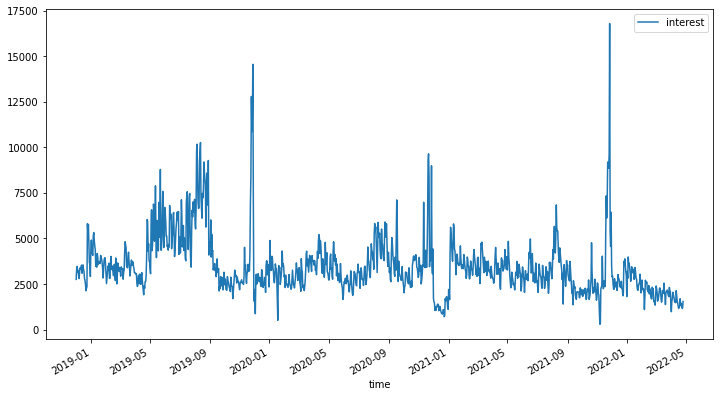

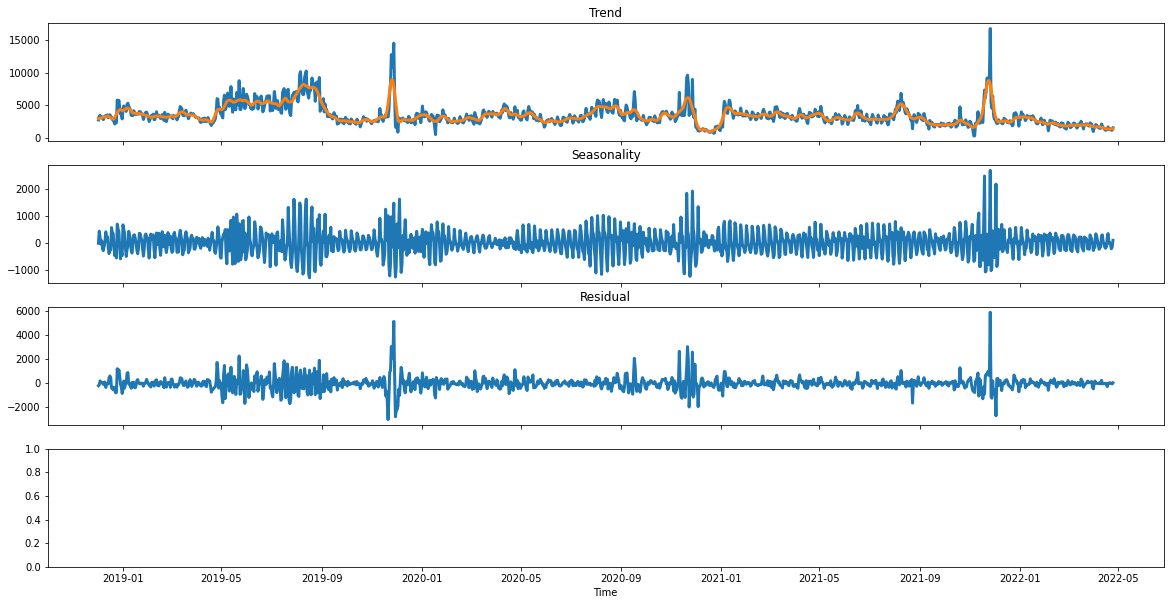

In [34]:
ts.plot()
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

In [35]:
# Detect seasonality
fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

In [36]:
outlier_detector = OutlierDetector(ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('2019-05-13 00:00:00'),
 Timestamp('2019-05-23 00:00:00'),
 Timestamp('2019-05-28 00:00:00'),
 Timestamp('2019-07-22 00:00:00'),
 Timestamp('2019-08-05 00:00:00'),
 Timestamp('2019-08-06 00:00:00'),
 Timestamp('2019-08-13 00:00:00'),
 Timestamp('2019-08-29 00:00:00'),
 Timestamp('2019-11-25 00:00:00'),
 Timestamp('2019-11-28 00:00:00'),
 Timestamp('2019-11-30 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-09-17 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2020-11-20 00:00:00'),
 Timestamp('2020-11-21 00:00:00'),
 Timestamp('2020-11-23 00:00:00'),
 Timestamp('2020-11-27 00:00:00'),
 Timestamp('2021-11-26 00:00:00'),
 Timestamp('2021-11-27 00:00:00'),
 Timestamp('2021-11-28 00:00:00')]

<AxesSubplot:xlabel='time'>

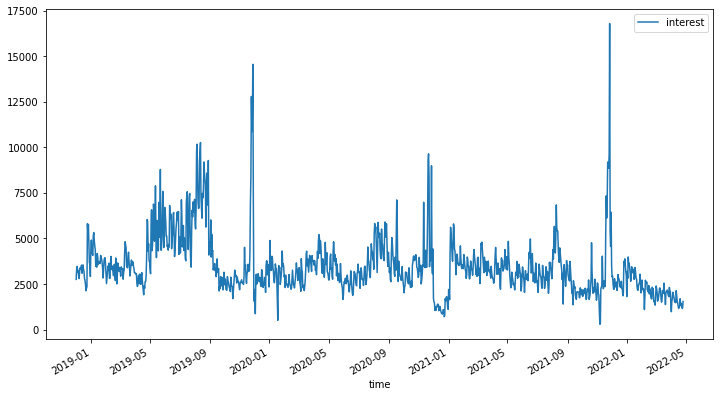

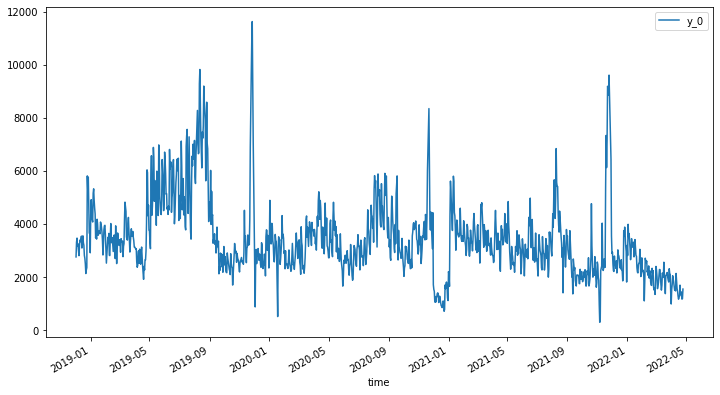

In [41]:
ts_outliers_interpolated = outlier_detector.remover(interpolate=True)
ts.plot()
ts_outliers_interpolated.plot()

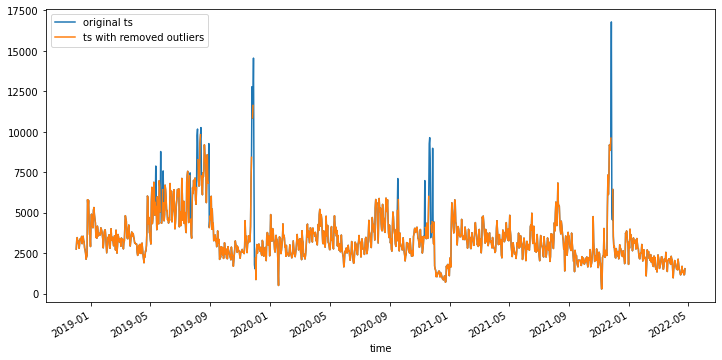

In [40]:
ax = ts.to_dataframe().plot(x="time", y="interest", figsize=(12, 6))
ts_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
plt.legend(labels=["original ts", "ts with removed outliers"])
plt.show()

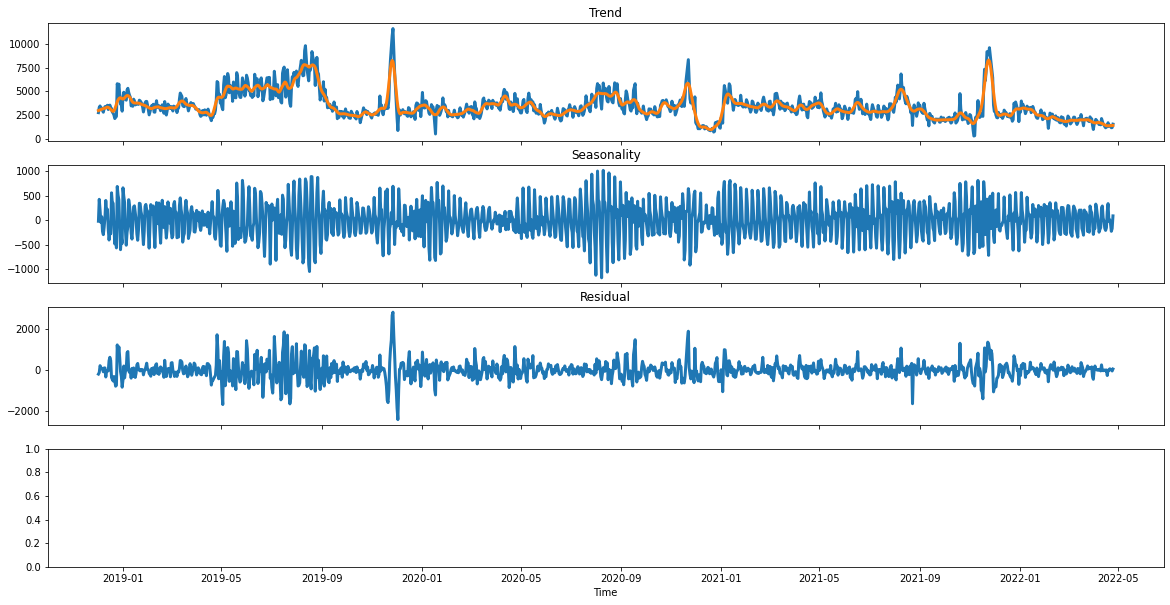

In [42]:

decomposer = TimeSeriesDecomposition(ts_outliers_interpolated, decomposition="additive")
results_outliers = decomposer.decomposer()
fig = decomposer.plot()

In [68]:
(results_outliers["seasonal"].to_dataframe()["season"] + results_outliers["seasonal"].to_dataframe()["season"])
results_outliers["rem"]

,time,resid
0,2018-12-02,-197.746683
1,2018-12-03,-125.142006
2,2018-12-04,210.330430
3,2018-12-05,125.528766
4,2018-12-06,60.940076
...,...,...
1236,2022-04-21,58.234221
1237,2022-04-22,43.143317
1238,2022-04-23,-0.053758
1239,2022-04-24,-46.411063
